# Exploration Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
from mpl_toolkits.mplot3d import Axes3D


# import clusters
from sklearn.cluster import KMeans

# ignore warnings to reduce clutter
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = wrangle.get_spotify_top_artists_discography_data()
train, validate, test = wrangle.split_data(df)
scaler, train_scaled, validate_scaled, test_scaled = wrangle.standard_scaler(train, validate, test)

In [3]:
df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_minutes
0,51,0.217,0.208,7,-11.112,1,0.0434,0.9670,0.01080,0.2920,0.0787,206.289,3,2
1,51,0.477,0.637,7,-7.244,1,0.0385,0.0560,0.01430,0.0904,0.5450,112.574,4,4
2,51,0.349,0.795,11,-5.813,0,0.0693,0.0302,0.00176,0.1300,0.4460,79.704,4,4
3,51,0.519,0.753,4,-5.334,1,0.0412,0.0161,0.00307,0.4480,0.3160,148.326,4,4
4,51,0.478,0.262,2,-10.825,1,0.0281,0.7180,0.58500,0.2320,0.0861,132.065,4,3


<AxesSubplot:ylabel='popularity'>

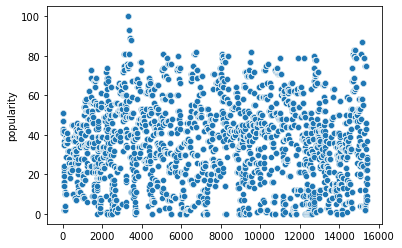

In [4]:
sns.scatterplot(y = 'popularity', x = df.index, data = df)

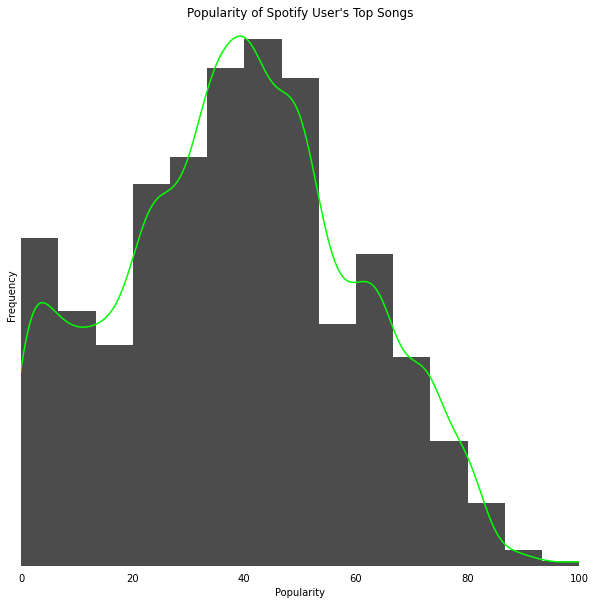

''

In [5]:
fig, ax = plt.subplots(figsize = (10,10))

df.popularity.plot(kind = 'hist', density = True, bins = 15, alpha = .7, color = 'k')
df.popularity.plot(kind = 'kde', color = 'lime')
plt.xlabel('Popularity')
ax.set_xlim(0,100)
plt.ylabel('Frequency')
ax.set_ylim(0,0.02)
ax.set_yticks([])
plt.title('Popularity of Spotify User\'s Top Songs')
ax.tick_params(left = False, bottom=False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
plt.show()
;

### Examine distributions

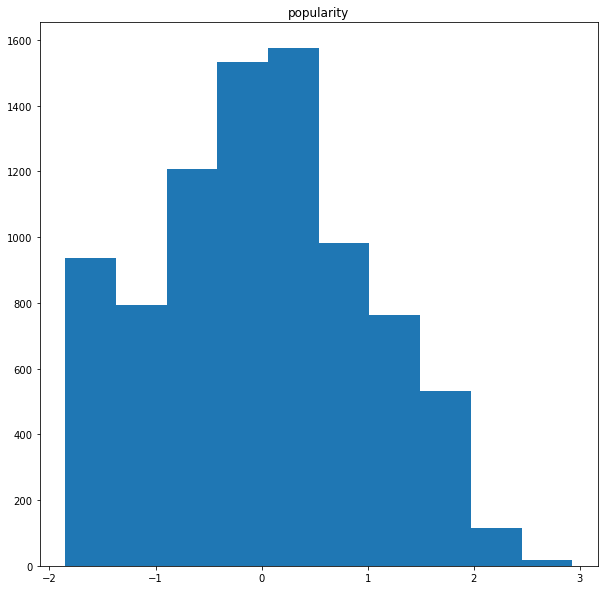

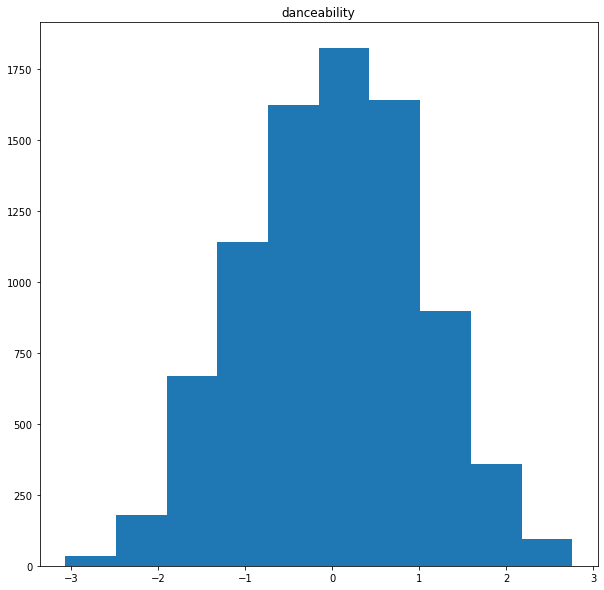

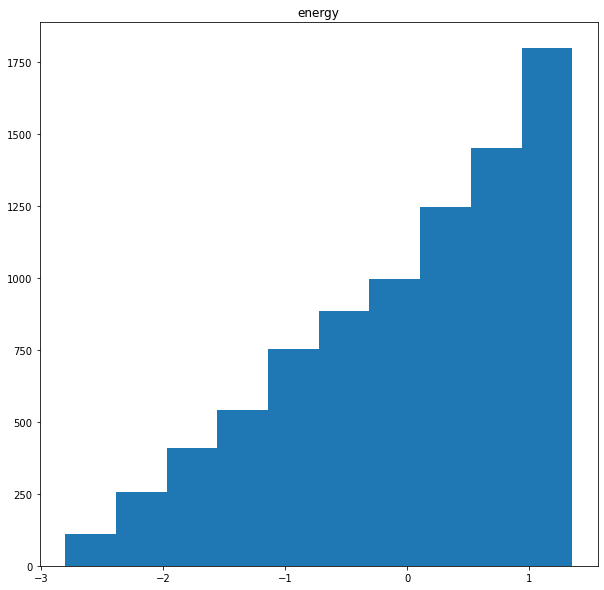

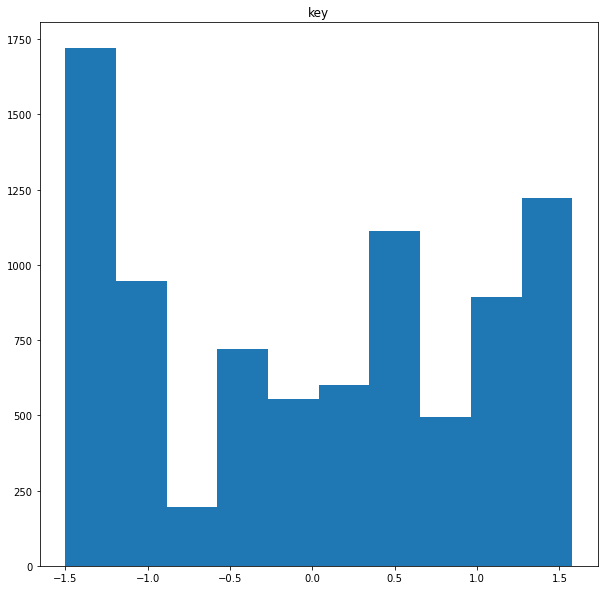

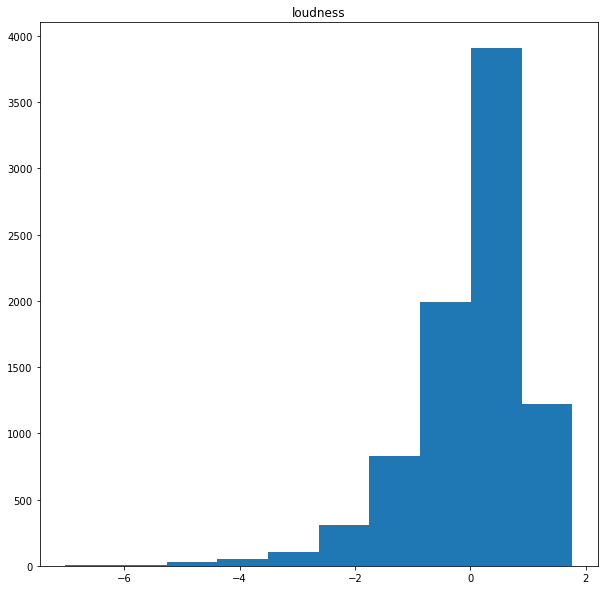

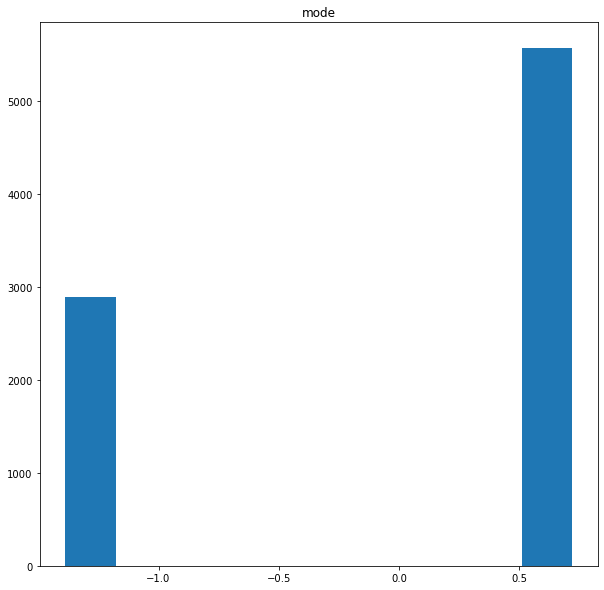

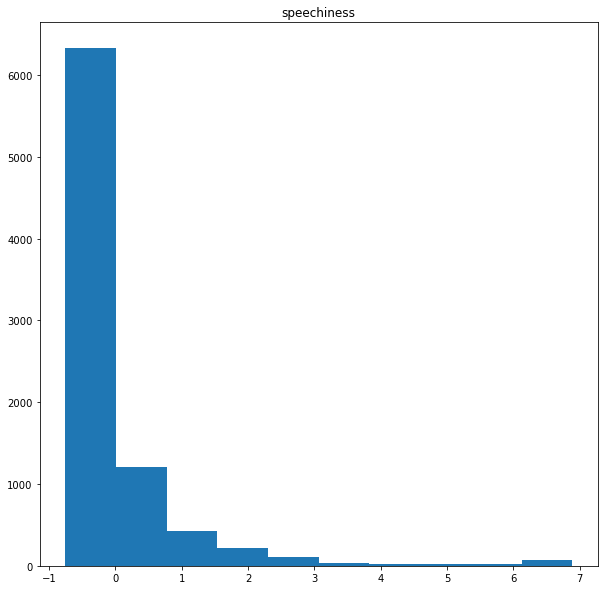

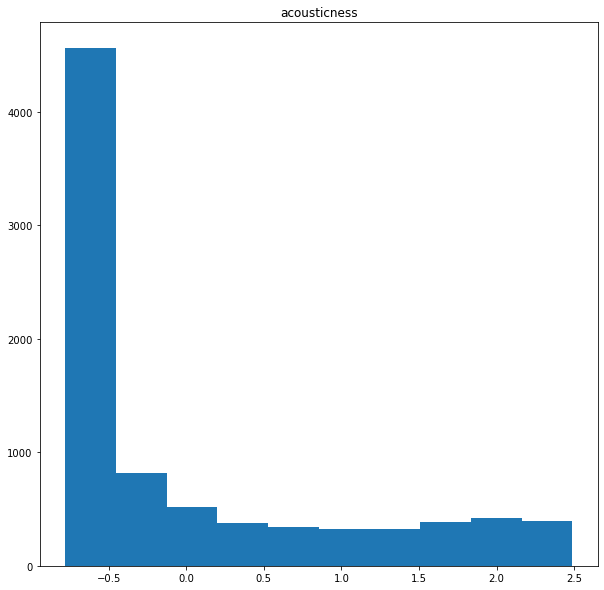

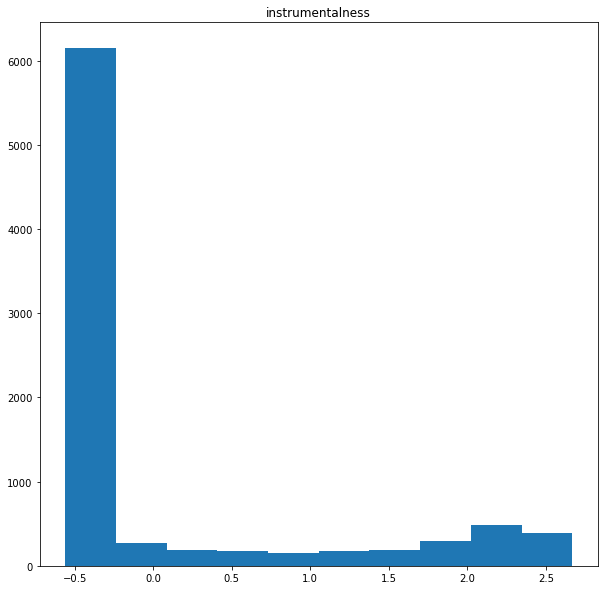

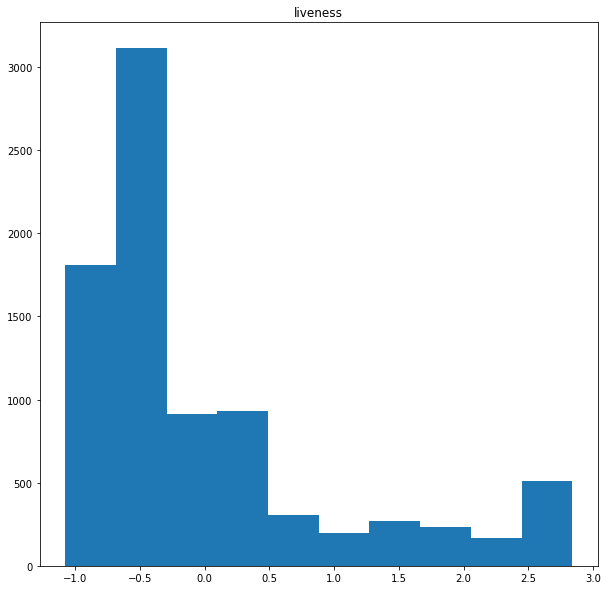

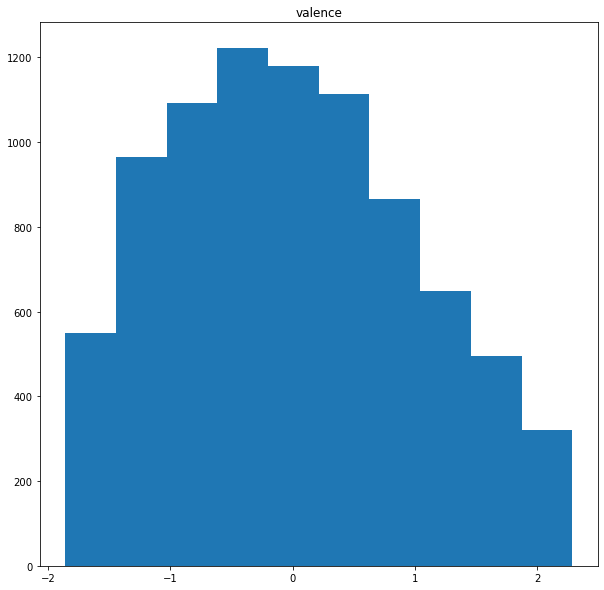

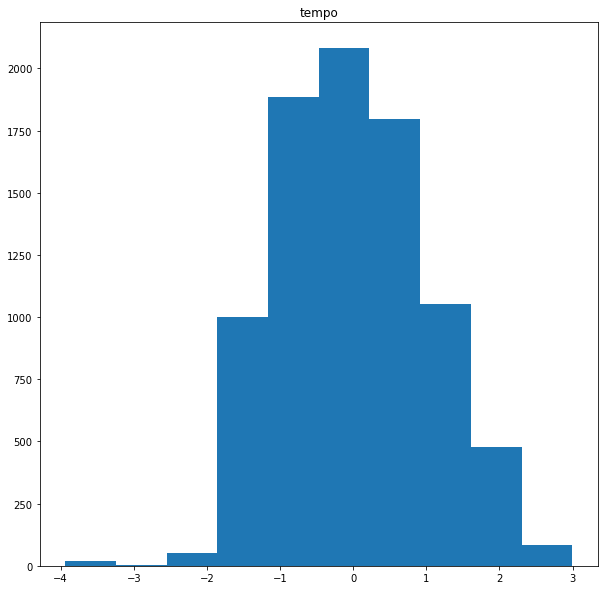

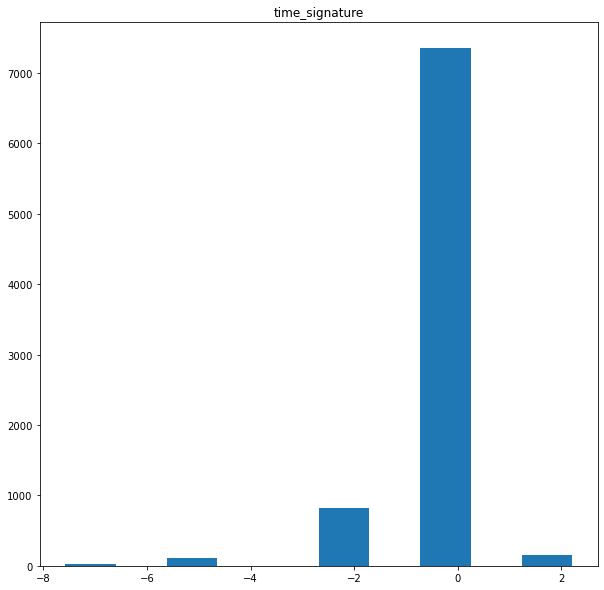

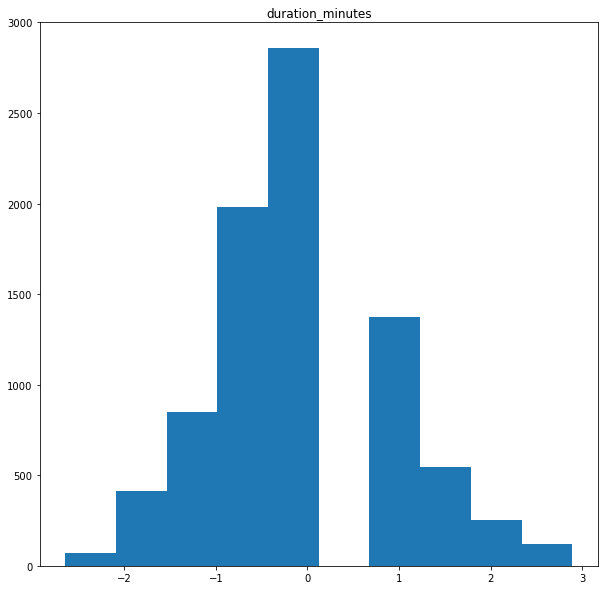

In [6]:
for col in train_scaled.columns.to_list():
    plt.figure(figsize=(10,10))
    plt.hist(train_scaled[col])
    plt.title(col)

### Check outliers

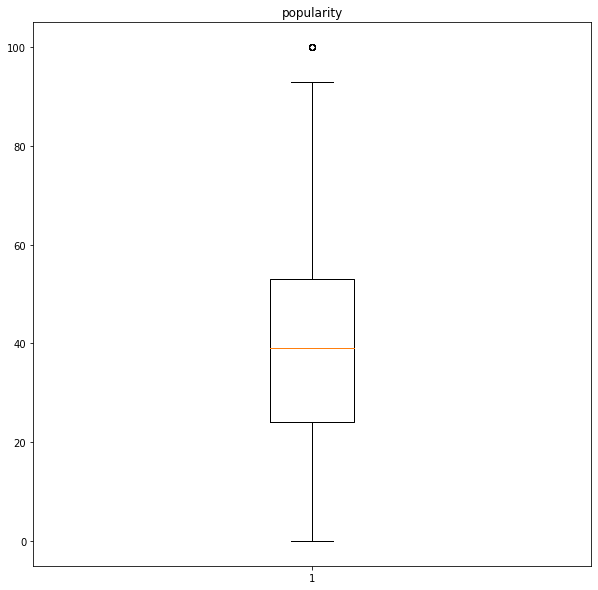

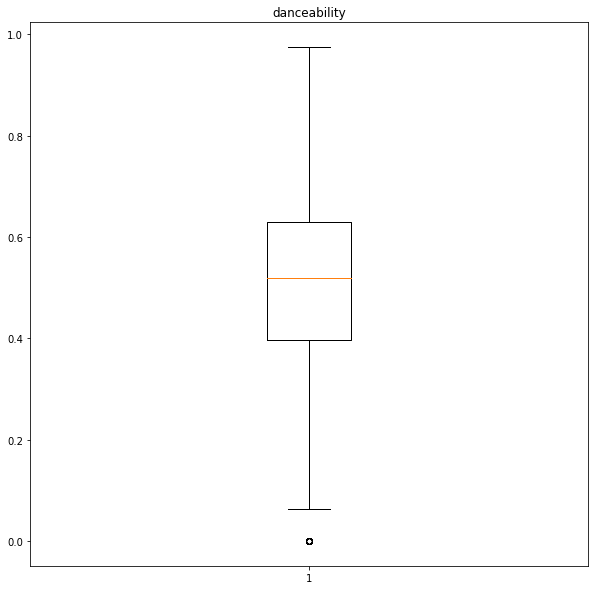

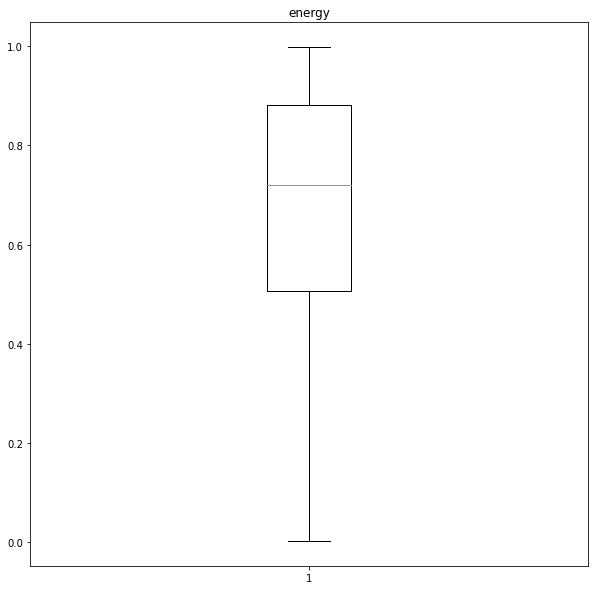

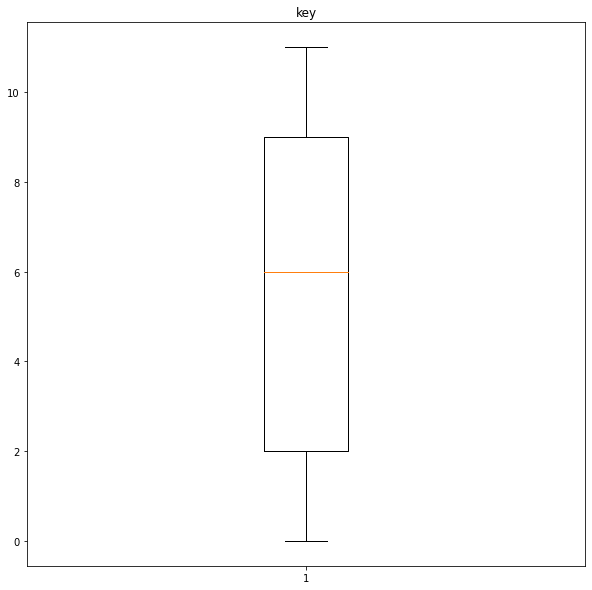

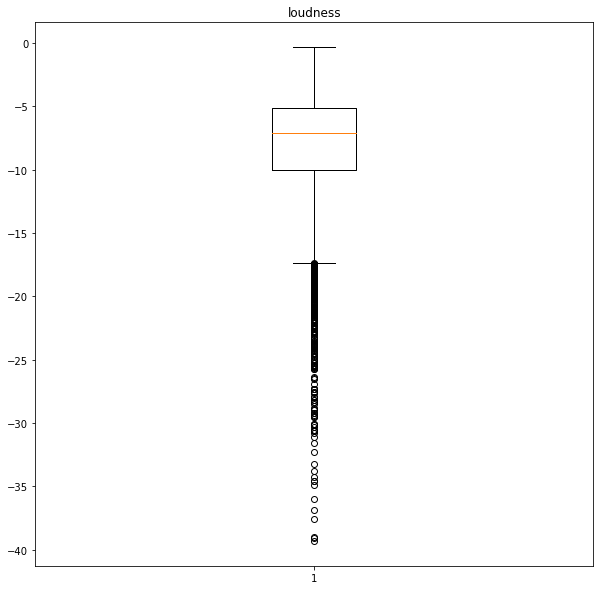

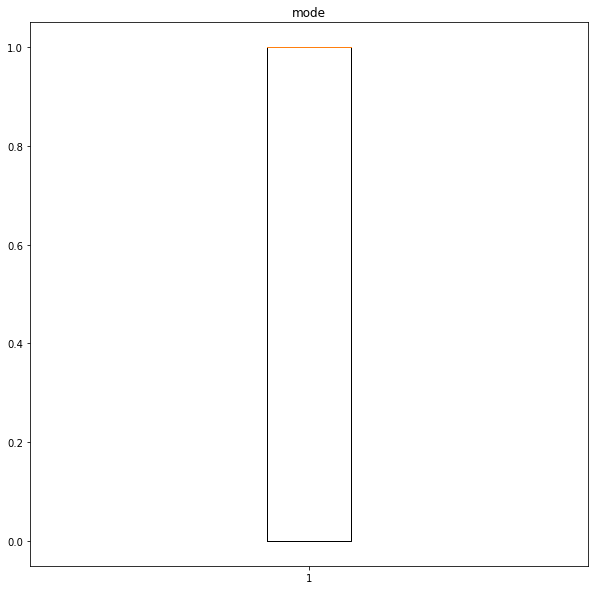

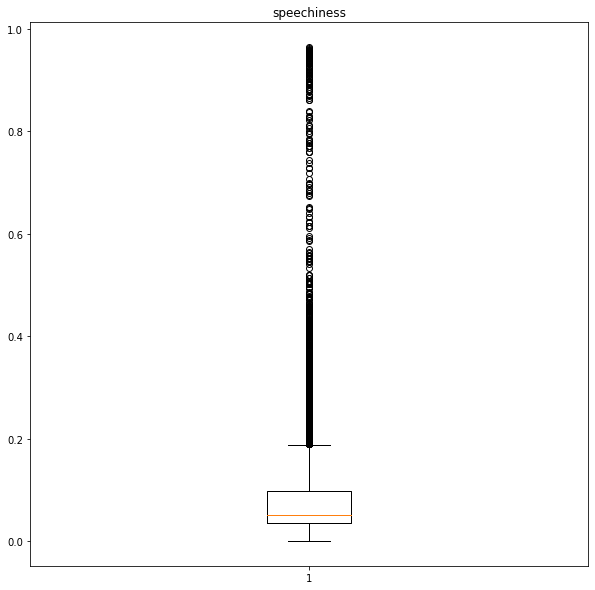

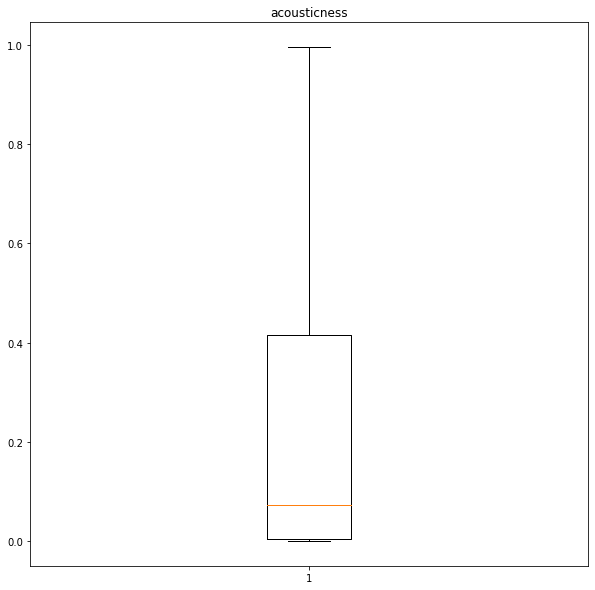

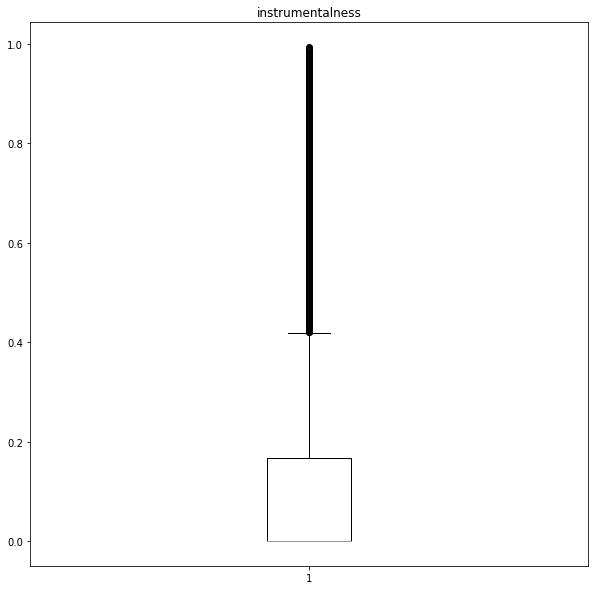

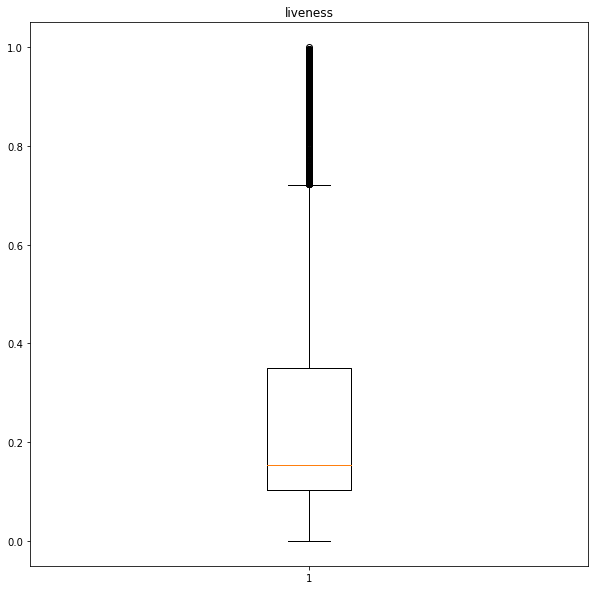

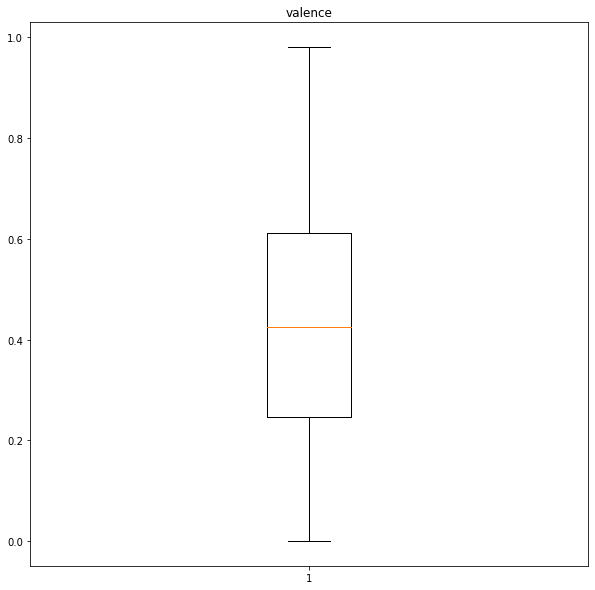

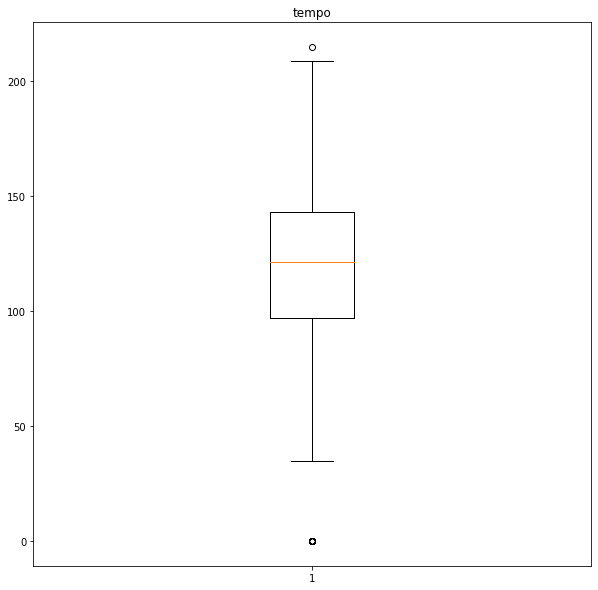

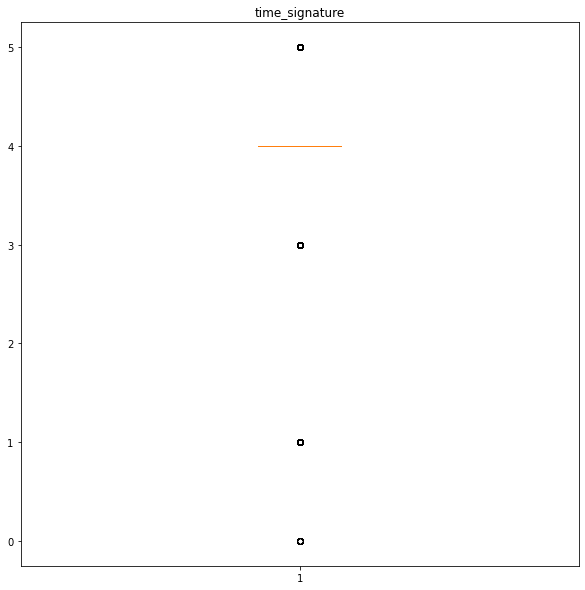

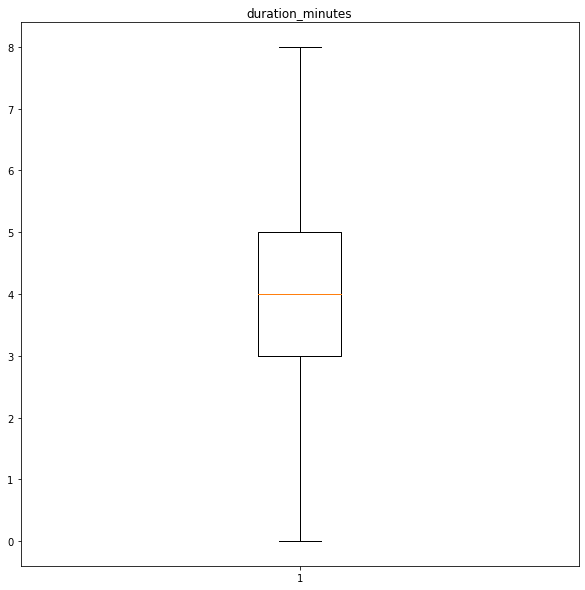

In [7]:
for col in train.columns.to_list():
    plt.figure(figsize=(10,10))
    plt.boxplot(train[col])
    plt.title(col)

### Visualize feature to popularity relationships

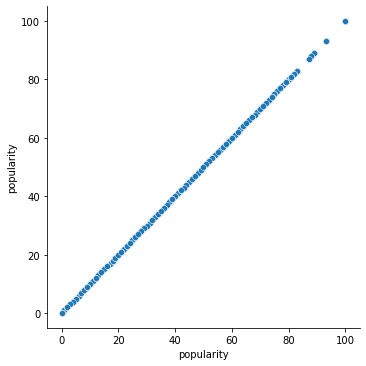

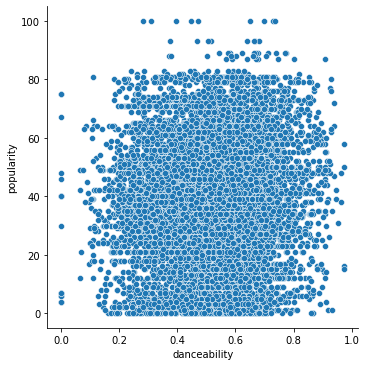

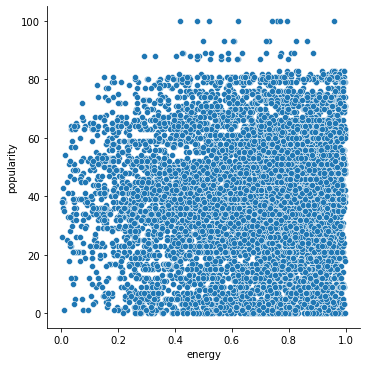

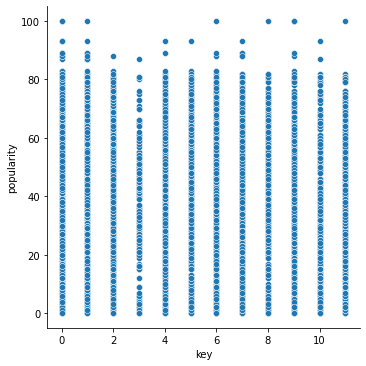

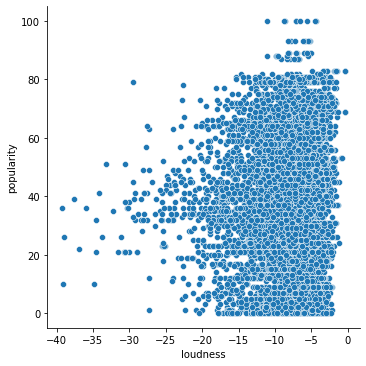

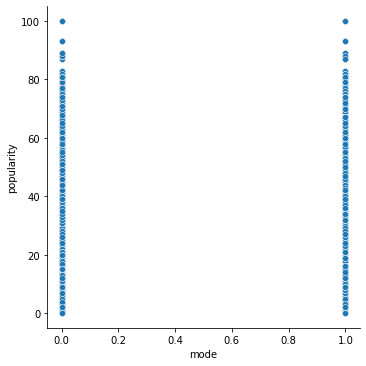

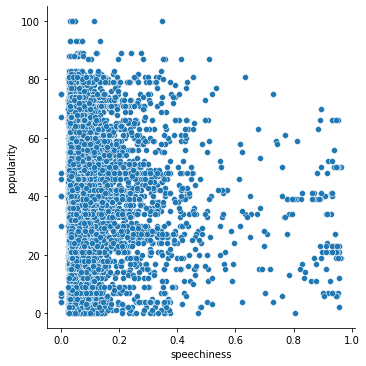

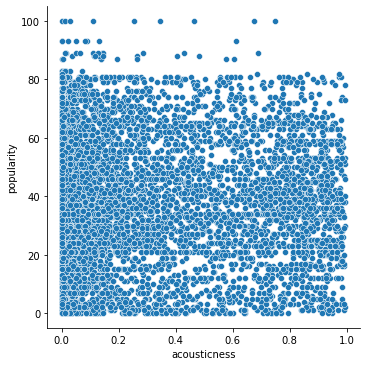

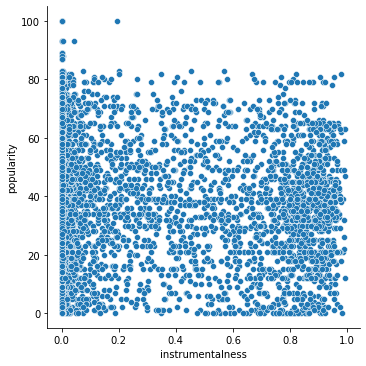

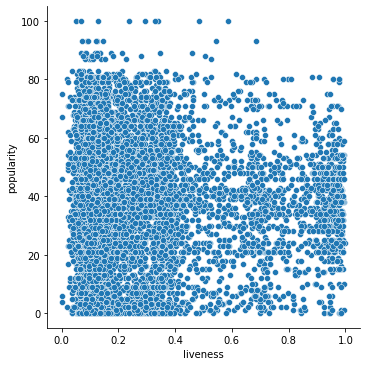

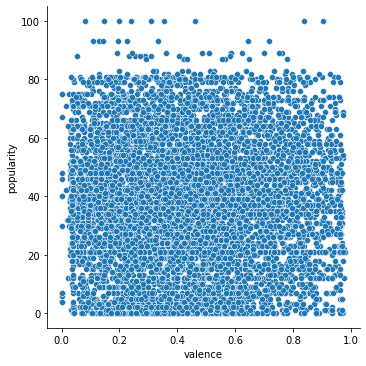

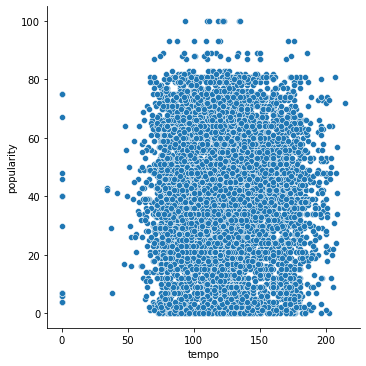

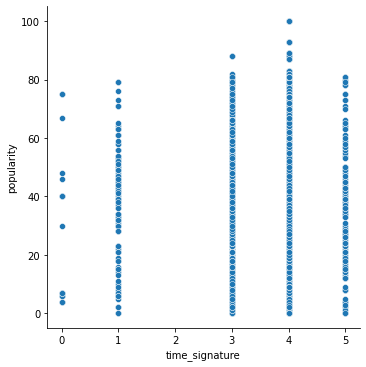

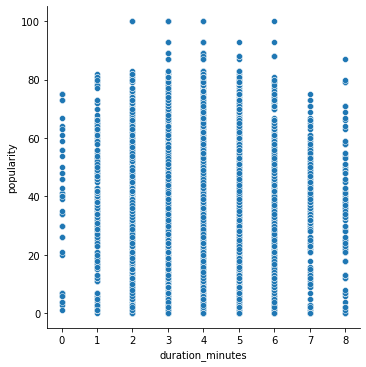

In [8]:
target = 'popularity'
for col in train.columns.to_list():
    sns.relplot(data = train, x = train[col], y = train[target])

Let's see what SelectKBest has to say about the audio features.

In [9]:
X_train = train.drop(columns = 'popularity')
y_train = train['popularity']

from sklearn.feature_selection import SelectKBest, f_regression

# our selecter is an f_regression stats test and retrieving 10 features
f_selector = SelectKBest(f_regression, k=10)

# find the top 5 features correlated with our target
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()

f_feature

['danceability',
 'energy',
 'loudness',
 'mode',
 'speechiness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature']

## Check clustering options
### What clusters make sense?
beat_cluster: tempo, energy, danceability

mood_cluster: mode, key, and valence

ambience_cluster: acousticness, intrumentalness, loudness

## Beat Cluster
tempo, energy, danceability, and loudness

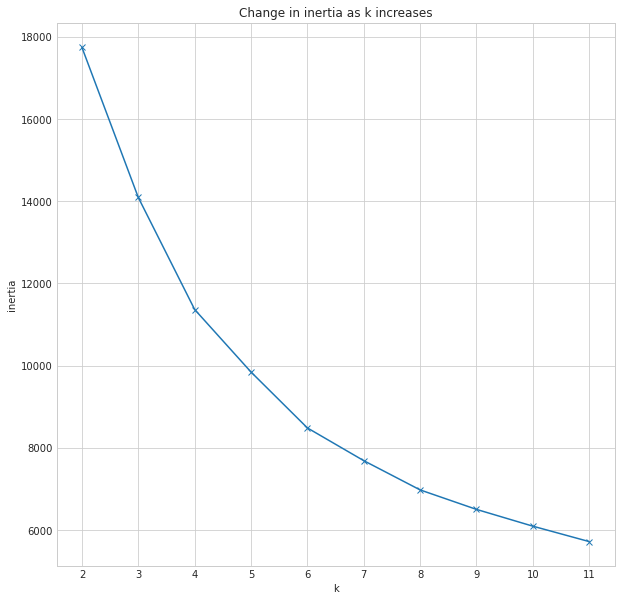

In [10]:
# define features for clustering
X_train_beat_cluster = train_scaled[['tempo','energy','danceability']]

# elbow method to find k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 10))
    pd.Series({k: KMeans(k).fit(X_train_beat_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [11]:
# create cluster features for validate and test
X_validate_beat_cluster = validate_scaled[['tempo','energy','danceability']]
X_test_beat_cluster = test_scaled[['tempo','energy','danceability']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_beat_cluster)
# use the object
train_scaled['beat_cluster'] = kmeans.predict(X_train_beat_cluster)
validate_scaled['beat_cluster'] = kmeans.predict(X_validate_beat_cluster)
test_scaled['beat_cluster'] = kmeans.predict(X_test_beat_cluster)
X_train_beat_cluster['beat_cluster'] = kmeans.predict(X_train_beat_cluster)

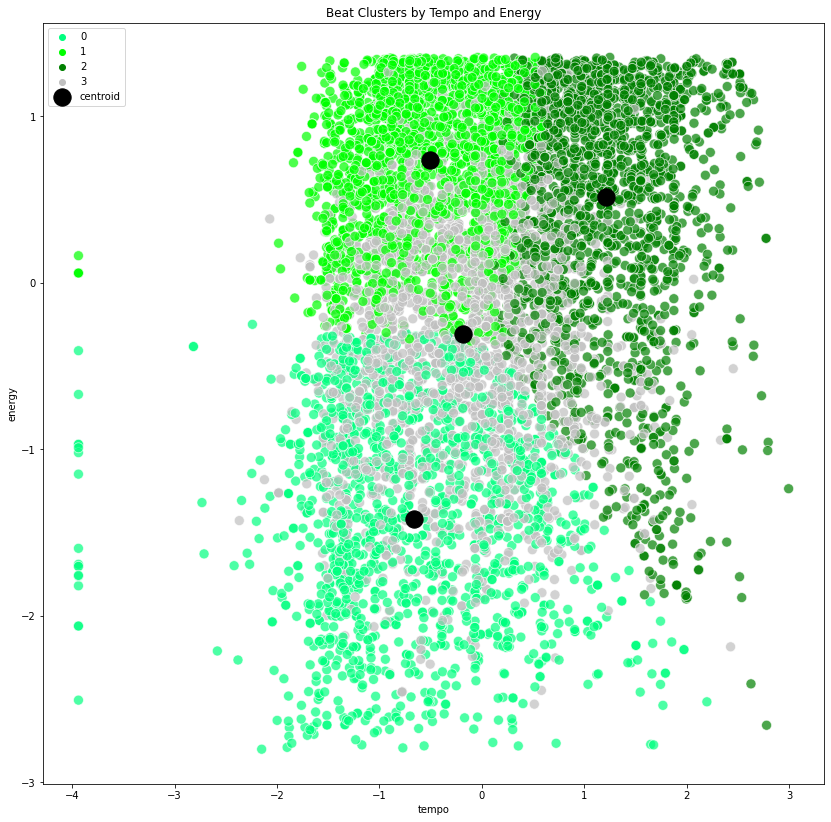

In [12]:
# define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_beat_cluster.loc[:, X_train_beat_cluster.columns != 'beat_cluster'].columns)
# visualize

plt.figure(figsize = (14,14))
sns.scatterplot(data = X_train_beat_cluster, x = 'tempo', y = 'energy', hue = 'beat_cluster', s = 100, alpha = 0.7, palette=['springgreen','lime','green','silver'])
centroids.plot.scatter(x='tempo',y='energy',ax = plt.gca(), color = 'black', s=300, label = 'centroid')
plt.title('Beat Clusters by Tempo and Energy')
plt.legend(loc = 'upper left')

Text(0.5, 0.92, 'Beat Clusters by Tempo and Energy')

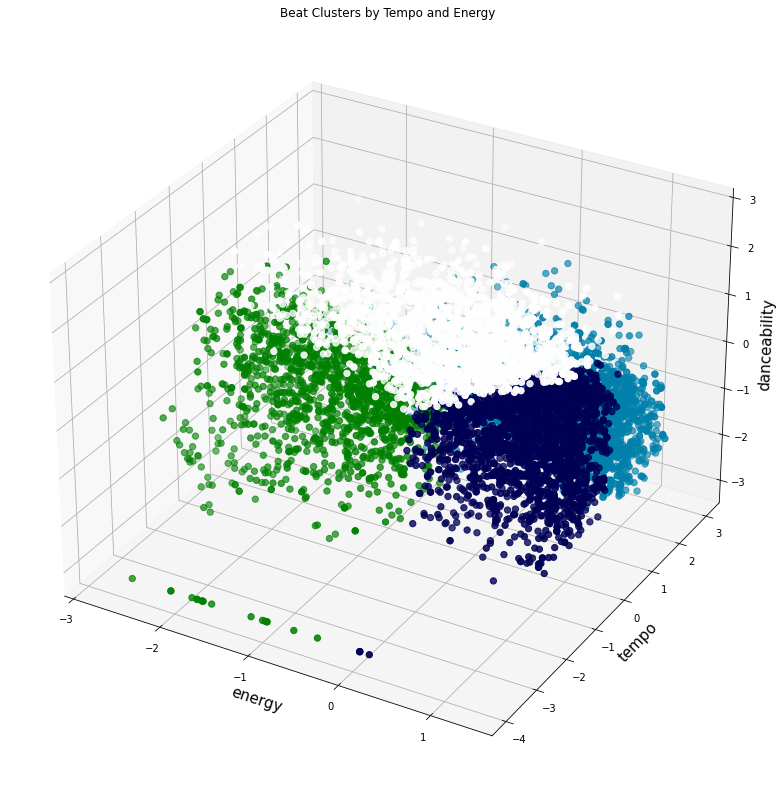

In [13]:
# plt.figure(figsize = (14,14))
fig = plt.figure(figsize = (14,14))
ax = fig.add_subplot(111, projection = '3d')

x = X_train_beat_cluster.energy
y = X_train_beat_cluster.tempo
z = X_train_beat_cluster.danceability
ax.scatter(x,y,z, c=X_train_beat_cluster.beat_cluster, s = 40, cmap='ocean')
# ax.legend()
ax.set_xlabel('energy', fontsize = 15)
ax.set_ylabel('tempo',fontsize = 15)
ax.set_zlabel('danceability',fontsize = 15)
plt.title('Beat Clusters by Tempo and Energy')

# sns.scatterplot(data = X_train_beat_cluster, x = 'energy', y = 'danceability', z = 'tempo', hue = 'beat_cluster', s = 100, alpha = 0.7, palette=['springgreen','lime','green','silver'])
# centroids.plot.scatter(x='energy',y='danceability', z = 'tempo', ax = plt.gca(), color = 'black', s=300, label = 'centroid')
# plt.legend(loc = 'upper left')
# plt.show()

## Mood Cluster

mode, key, and valence


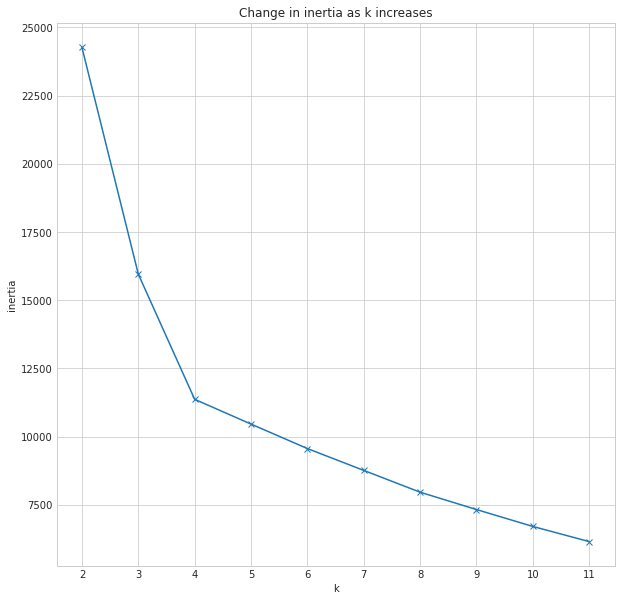

In [14]:
# define features for clustering
X_train_mood_cluster = train_scaled[['mode','key','valence']]

# elbow method to find k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 10))
    pd.Series({k: KMeans(k).fit(X_train_beat_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [15]:
# create cluster features for validate and test
X_validate_mood_cluster = validate_scaled[['mode','key','valence']]
X_test_mood_cluster = test_scaled[['mode','key','valence']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_mood_cluster)
# use the object
train_scaled['mood_cluster'] = kmeans.predict(X_train_mood_cluster)
validate_scaled['mood_cluster'] = kmeans.predict(X_validate_mood_cluster)
test_scaled['mood_cluster'] = kmeans.predict(X_test_mood_cluster)
X_train_mood_cluster['mood_cluster'] = kmeans.predict(X_train_mood_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_mood_cluster.loc[:, X_train_mood_cluster.columns != 'mood_cluster'].columns)

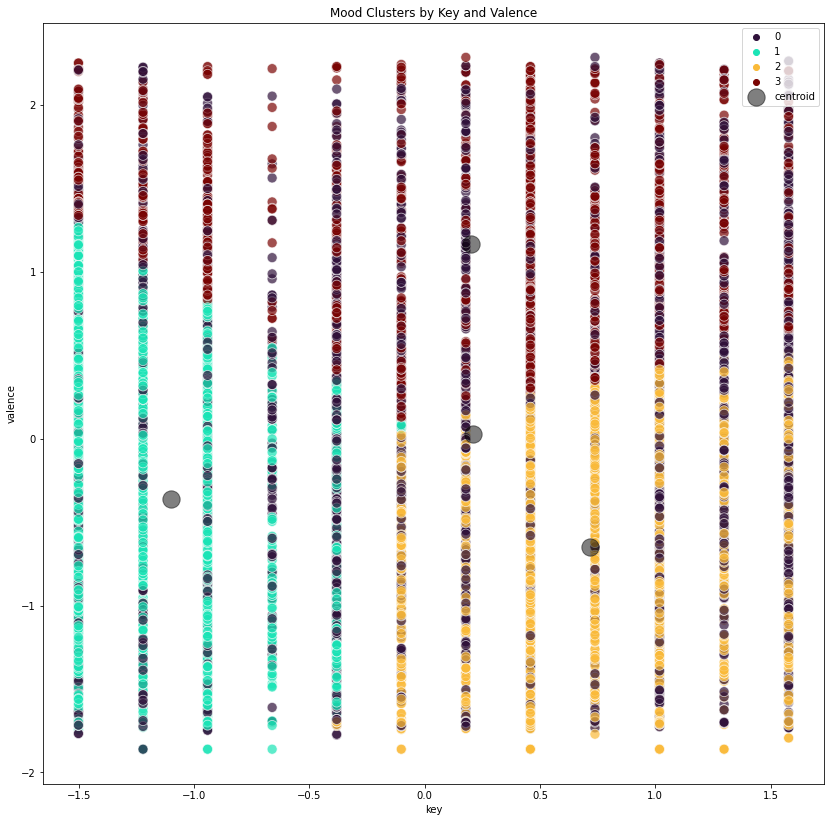

In [16]:
# visualize
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_mood_cluster.loc[:, X_train_mood_cluster.columns != 'mood_cluster'].columns)
plt.figure(figsize = (14,14))
sns.scatterplot(data = X_train_mood_cluster, x = 'key', y = 'valence', hue = 'mood_cluster', s = 100, alpha = 0.7, palette='turbo')
centroids.plot.scatter(x='key',y='valence',ax = plt.gca(), color = 'black',alpha = 0.5, s=300, label = 'centroid')
plt.title('Mood Clusters by Key and Valence')
plt.legend(loc = 'upper right')

## Ambience Cluster
acousticness and intrumentalness

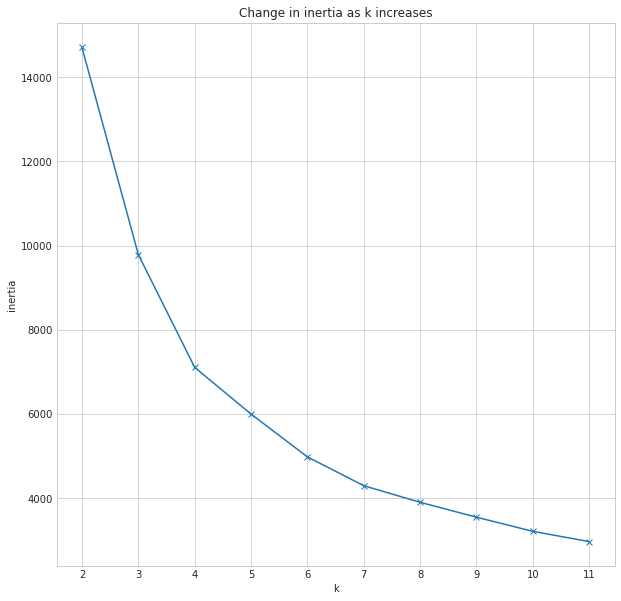

In [17]:
# define features for clustering
X_train_ambience_cluster = train_scaled[['acousticness','instrumentalness','loudness']]

# elbow method to find k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 10))
    pd.Series({k: KMeans(k).fit(X_train_ambience_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [18]:
# create cluster features for validate and test
X_validate_ambience_cluster = validate_scaled[['acousticness','instrumentalness','loudness']]
X_test_ambience_cluster = test_scaled[['acousticness','instrumentalness','loudness']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_ambience_cluster)
# use the object
train_scaled['ambience_cluster'] = kmeans.predict(X_train_ambience_cluster)
validate_scaled['ambience_cluster'] = kmeans.predict(X_validate_ambience_cluster)
test_scaled['ambience_cluster'] = kmeans.predict(X_test_ambience_cluster)
X_train_ambience_cluster['ambience_cluster'] = kmeans.predict(X_train_ambience_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_ambience_cluster.loc[:, X_train_ambience_cluster.columns != 'ambience_cluster'].columns)

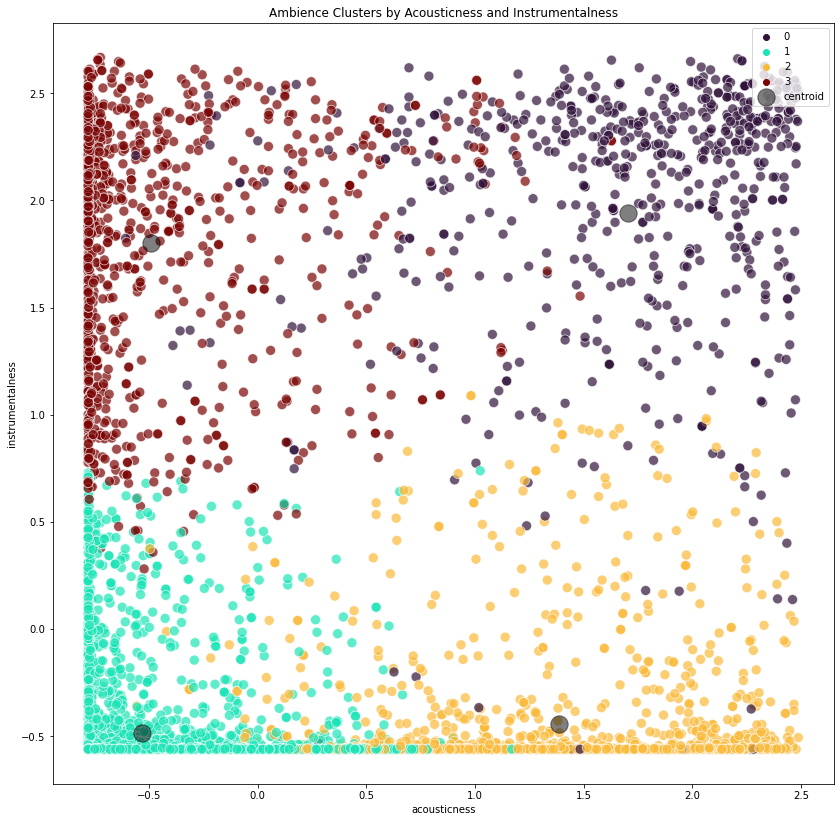

In [19]:
# visualize
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_ambience_cluster.loc[:, X_train_ambience_cluster.columns != 'ambience_cluster'].columns)
plt.figure(figsize = (14,14))
sns.scatterplot(data = X_train_ambience_cluster, x = 'acousticness', y = 'instrumentalness', hue = 'ambience_cluster', s = 100, alpha = 0.7, palette='turbo')
centroids.plot.scatter(x='acousticness',y='instrumentalness',ax = plt.gca(), color = 'black',alpha = 0.5, s=300, label = 'centroid')
plt.title('Ambience Clusters by Acousticness and Instrumentalness')
plt.legend(loc = 'upper right')

In [20]:
X_train = train_scaled.drop(columns = 'popularity')
y_train = train_scaled['popularity']

from sklearn.feature_selection import SelectKBest, f_regression

# our selecter is an f_regression stats test and retrieving 10 features
f_selector = SelectKBest(f_regression, k=10)

# find the top 5 features correlated with our target
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()

f_feature

['danceability',
 'loudness',
 'mode',
 'instrumentalness',
 'liveness',
 'valence',
 'time_signature',
 'beat_cluster',
 'mood_cluster',
 'ambience_cluster']

## Clustering Summary

The mood clusters has too much overlap to be useful, I expect this is because the features included are mostly categorical in nature.

The beat and ambience clusters have a pretty distinct split and even appeared on SelectKBest, I'll run statistical tests and visualize the clusters with popularity in the next section.

# Statistical Tests

Finding correlation between audio features and popularity

In [21]:
train.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_minutes
14535,50,0.883,0.781,7,-7.384,1,0.1410,0.1520,0.014200,0.105,0.780,115.011,4,3
14392,59,0.764,0.237,9,-15.246,1,0.2660,0.8960,0.962000,0.105,0.230,80.960,4,2
4641,63,0.485,0.319,5,-8.525,1,0.0310,0.6860,0.000028,0.117,0.195,142.119,3,5
5944,66,0.519,0.880,6,-3.929,1,0.0447,0.0226,0.000000,0.135,0.529,144.968,4,4
9466,26,0.292,0.830,1,-1.710,0,0.0377,0.2900,0.000004,0.116,0.155,151.964,4,4


# Modeling
Popularity is a continuous target from 0-100 so I will use linear regression models to make predictions.

In [22]:
#import linear regression modules
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
#import evaluation metrics
from sklearn.metrics import mean_squared_error

### I'll use the SelectKBest recommendations to create filters for, allowing my models to use only a few features. This is to add variety in modeling and to see how clustering may enhance or distract the model.

In [23]:
print(f_feature)
# from my SelectKBest I remove the features I clustered with to create models with what remains and the clusters.
model_cluster_features = ['mode', 'liveness', 'duration_minutes', 'beat_cluster','ambience_cluster']
# create features from the first SelectKBest that excludes clusters.
model_no_cluster_features = ['danceability', 'energy', 'loudness', 'mode', 'acousticness', 'instrumentalness']

['danceability', 'loudness', 'mode', 'instrumentalness', 'liveness', 'valence', 'time_signature', 'beat_cluster', 'mood_cluster', 'ambience_cluster']


### All feature modeling setup

In [24]:
# Create X and y for train, validate, test with no feature mask.
X_train = train_scaled.drop(columns=['popularity'])
y_train = train['popularity']

X_validate = validate_scaled.drop(columns=['popularity'])
y_validate = validate['popularity']

X_test = test_scaled.drop(columns=['popularity'])
y_test = test['popularity']

### Cluster modeling setup

In [25]:
# Create X for train, validate, test, applying the model_cluster_features mask.
X_train_cluster = train_scaled[model_cluster_features]

X_validate_cluster = validate_scaled[model_cluster_features]

X_test_cluster = test_scaled[model_cluster_features]

### No Cluster modeling setup

In [26]:
X_train_no_cluster = train_scaled[model_no_cluster_features]

X_validate_no_cluster = validate_scaled[model_no_cluster_features]

X_test_no_cluster = test_scaled[model_no_cluster_features]

## Baseline
Create a baseline model using the mean popularity

In [27]:
# Create dataframes of the target for modeling purposes
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# predict mean
pred_mean = y_train.popularity.mean()
y_train['baseline_pred_mean'] = pred_mean
y_validate['baseline_pred_mean'] = pred_mean

# RMSE of mean
rmse_train = mean_squared_error(y_train.popularity, y_train.baseline_pred_mean)**(1/2)
print("Train/In-Sample RMSE: ", rmse_train)

# validate rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.baseline_pred_mean)**(1/2)
print("Validate/Out-of-Sample RMSE: ", rmse_validate)
baseline_rmse = rmse_validate
# df with all RMSE
model_eval = pd.DataFrame([{'baseline':rmse_validate}])

Train/In-Sample RMSE:  20.908177508167526
Validate/Out-of-Sample RMSE:  20.863228238756907


## Model 1: OLS All Features

In [28]:
# Create model
lm = LinearRegression(normalize=True,)

# fit the model to training data.
lm.fit(X_train, y_train.popularity)

# predict train
y_train['popularity_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm)**(1/2)

print("Training/In-Sample RMSE: ", rmse_train)

Training/In-Sample RMSE:  20.554756973148812


### Evaluate on Validate

In [29]:
# predict validate
y_validate['popularity_pred_lm'] = lm.predict(X_validate)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm)**(1/2)

print("Validation/Out-of-Sample RMSE:", rmse_validate)

model_eval['ols_all'] = rmse_validate

Validation/Out-of-Sample RMSE: 20.48823991897618


## Model 2: GLM All Features

In [30]:
# create the model object
glm = TweedieRegressor(power = 0, alpha=0.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.popularity)

# predict train
y_train['popularity_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train) 

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  20.622925624252296


### Evaluate on Validate

In [31]:
# predict validate
y_validate['popularity_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_glm)**(1/2)

print("Validation/Out-of-Sample: ", rmse_validate)
model_eval['glm_all'] = rmse_validate

Validation/Out-of-Sample:  20.532898277023566


## Model 3: Polynomial Model All Features

In [32]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate & X_test
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
lm2.fit(X_train_degree2, y_train.popularity)

# predict train
y_train['popularity_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  20.198558318740947


### Evaluate on Validate

In [33]:
# predict validate
y_validate['popularity_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm2)**(1/2)

print('Validation/Out-of-Sample:', rmse_validate)
model_eval['lm2_all'] = rmse_validate


Validation/Out-of-Sample: 20.326966988677743


## Model 4: OLS Model with Clusters

In [34]:
# Create model
lm_cluster = LinearRegression(normalize=True,)

# fit the model to training data.
lm_cluster.fit(X_train_cluster, y_train.popularity)

# predict train
y_train['popularity_pred_lm_cluster'] = lm_cluster.predict(X_train_cluster)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm_cluster)**(1/2)

print("Training/In-Sample RMSE: ", rmse_train)

Training/In-Sample RMSE:  20.79377299295203


### Evaluate on Validate

In [35]:
# predict validate
y_validate['popularity_pred_lm_cluster'] = lm_cluster.predict(X_validate_cluster)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm_cluster)**(1/2)

print("Validation/Out-of-Sample RMSE:", rmse_validate)
model_eval['ols_clusters'] = rmse_validate

Validation/Out-of-Sample RMSE: 20.71053069968946


## Model 5: GLM with Clusters

In [36]:
# create the model object
glm_cluster = TweedieRegressor(power = 0, alpha=0.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm_cluster.fit(X_train_cluster, y_train.popularity)

# predict train
y_train['popularity_pred_glm_cluster'] = glm_cluster.predict(X_train_cluster)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_glm_cluster)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train) 

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  20.81103431934699


### Evaluate on Validate

In [37]:
# predict validate
y_validate['popularity_pred_glm_cluster'] = glm_cluster.predict(X_validate_cluster)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_glm_cluster)**(1/2)

print("Validation/Out-of-Sample: ", rmse_validate)
model_eval['glm_clusters'] = rmse_validate

Validation/Out-of-Sample:  20.737923101943394


## Model 6: Polynomial with Clusters

In [38]:
# make the polynomial features to get a new set of features
pf_cluster = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_cluster_degree2 = pf_cluster.fit_transform(X_train_cluster)

# transform X_validate & X_test
X_validate_cluster_degree2 = pf_cluster.transform(X_validate_cluster)
X_test_cluster_degree2 = pf_cluster.transform(X_test_cluster)

# create the model object
lm2_cluster = LinearRegression(normalize=True)

# fit the model to our training data.
lm2_cluster.fit(X_train_cluster_degree2, y_train.popularity)

# predict train
y_train['popularity_pred_lm2_cluster'] = lm2_cluster.predict(X_train_cluster_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm2_cluster)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  20.70083900065268


### Evaluate on Validate

In [39]:
# predict validate
y_validate['popularity_pred_lm2_cluster'] = lm2_cluster.predict(X_validate_cluster_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm2_cluster)**(1/2)

print('Validation/Out-of-Sample:', rmse_validate)
model_eval['lm2_clusters'] = rmse_validate

Validation/Out-of-Sample: 20.63436930937641


## Model 7: OLS without Clusters

In [40]:
# Create model
lm_no_cluster = LinearRegression(normalize=True,)

# fit the model to training data.
lm_no_cluster.fit(X_train_cluster, y_train.popularity)

# predict train
y_train['popularity_pred_lm_no_cluster'] = lm_no_cluster.predict(X_train_cluster)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm_no_cluster)**(1/2)

print("Training/In-Sample RMSE: ", rmse_train)

Training/In-Sample RMSE:  20.79377299295203


### Evaluate on Validate

In [41]:
# predict validate
y_validate['popularity_pred_lm_no_cluster'] = lm_no_cluster.predict(X_validate_cluster)

# evaluate rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm_no_cluster)**(1/2)

print("Validation/Out-of-Sample RMSE:", rmse_validate)
model_eval['ols_no_clusters'] = rmse_validate

Validation/Out-of-Sample RMSE: 20.71053069968946


## Model 8: GLM without Clusters

In [42]:
# create the model object
glm_no_cluster = TweedieRegressor(power = 0, alpha=0)

# fit the model to our training data
glm_no_cluster.fit(X_train_cluster, y_train.popularity)

# predict train
y_train['popularity_pred_glm_no_cluster'] = glm_no_cluster.predict(X_train_cluster)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_glm_no_cluster)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train) 

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  20.79377299295467


### Evaluate on Validate

In [43]:
# predict validate
y_validate['popularity_pred_glm_no_cluster'] = glm_no_cluster.predict(X_validate_cluster)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_glm_no_cluster)**(1/2)

print("Validation/Out-of-Sample: ", rmse_validate)
model_eval['glm_no_clusters'] = rmse_validate

Validation/Out-of-Sample:  20.710530926708312


## Model 9: Polynomial without Clusters

In [44]:
# make the polynomial features to get a new set of features
pf_no_cluster = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_no_cluster_degree2 = pf_no_cluster.fit_transform(X_train_cluster)

# transform X_validate & X_test
X_validate_no_cluster_degree2 = pf_no_cluster.transform(X_validate_cluster)
X_test_no_cluster_degree2 = pf_no_cluster.transform(X_test_cluster)

# create the model object
lm2_no_cluster = LinearRegression(normalize=True)

# fit the model to our training data.
lm2_no_cluster.fit(X_train_no_cluster_degree2, y_train.popularity)

# predict train
y_train['popularity_pred_lm2_no_cluster'] = lm2_no_cluster.predict(X_train_no_cluster_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm2_no_cluster)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  20.70083900065268


### Evaluate on Validate

In [45]:
# predict validate
y_validate['popularity_pred_lm2_no_cluster'] = lm2_no_cluster.predict(X_validate_cluster_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm2_no_cluster)**(1/2)

print('Validation/Out-of-Sample:', rmse_validate)
model_eval['lm2_no_clusters'] = rmse_validate

Validation/Out-of-Sample: 20.63436930937641


### Compare all RMSE

In [46]:
# Clean the model evaluation dataframe
model_eval = model_eval.T.reset_index().rename(columns={'index':'model',0:'RMSE'})

In [47]:
# Find the lowest RMSE
model_eval[model_eval.RMSE == model_eval.RMSE.min()]

,model,RMSE
3,lm2_all,20.326967


In [48]:
model_eval['baseline_RMSE'] = model_eval[model_eval.model == 'baseline'].RMSE.max()
model_eval['baseline_diff'] = model_eval.baseline_RMSE - model_eval.RMSE
model_eval['percent_diff'] = (model_eval.baseline_diff / model_eval.baseline_RMSE) * 100

In [49]:
model_eval

,model,RMSE,baseline_RMSE,baseline_diff,percent_diff
0,baseline,20.863228,20.863228,0.000000,0.000000
1,ols_all,20.488240,20.863228,0.374988,1.797365
2,glm_all,20.532898,20.863228,0.330330,1.583312
3,lm2_all,20.326967,20.863228,0.536261,2.570366
4,ols_clusters,20.710531,20.863228,0.152698,0.731898
5,glm_clusters,20.737923,20.863228,0.125305,0.600603
6,lm2_clusters,20.634369,20.863228,0.228859,1.096949
7,ols_no_clusters,20.710531,20.863228,0.152698,0.731898
8,glm_no_clusters,20.710531,20.863228,0.152697,0.731897
9,lm2_no_clusters,20.634369,20.863228,0.228859,1.096949


The polynomial model with all features and clusters included is the best performing model, beating the baseline by 2.57%.

## Validate with Visuals

### All Features
The models with all features included performed the best so I will only examine them.

In [50]:
pred_mean

38.74012301868938

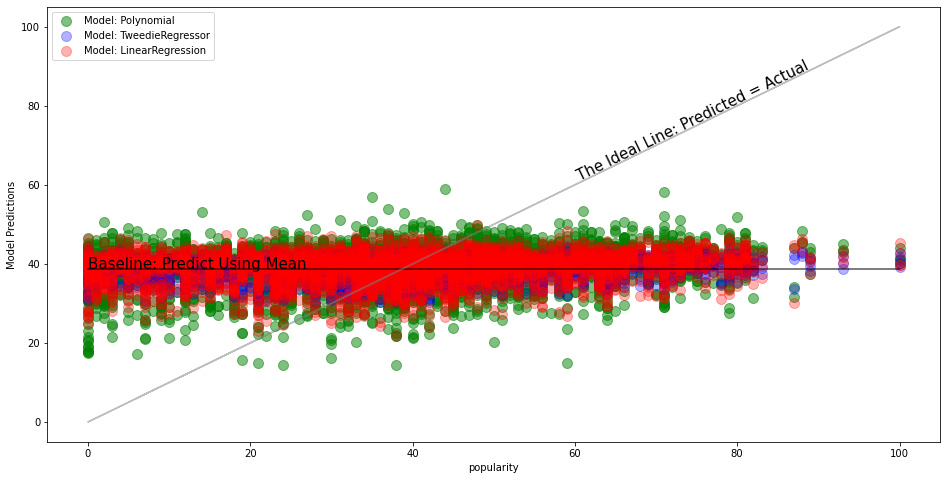

In [51]:
plt.figure(figsize = (16,8))
plt.plot(y_validate.popularity, y_validate.baseline_pred_mean, alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (0, (pred_mean + 0.1)), size = 15)
plt.plot(y_validate.popularity, y_validate.popularity, alpha=.5, color="grey", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (60, 61),size = 15,rotation=26)
plt.scatter(y_validate.popularity, y_validate.popularity_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model: Polynomial")
# plt.scatter(y_validate.popularity, y_validate.popularity_pred_lars, 
#             alpha=.5, color="green", s=100, label="Model: LassoLars")
plt.scatter(y_validate.popularity, y_validate.popularity_pred_glm,
            alpha=.3, color="blue",s=100,label='Model: TweedieRegressor')
plt.scatter(y_validate.popularity, y_validate.popularity_pred_lm, 
            alpha=.3, color="red", s=100, label="Model: LinearRegression")
plt.xlabel('popularity')
plt.ylabel('Model Predictions')
plt.legend()

The Polynomial model is slightly better fit to the ideal line.

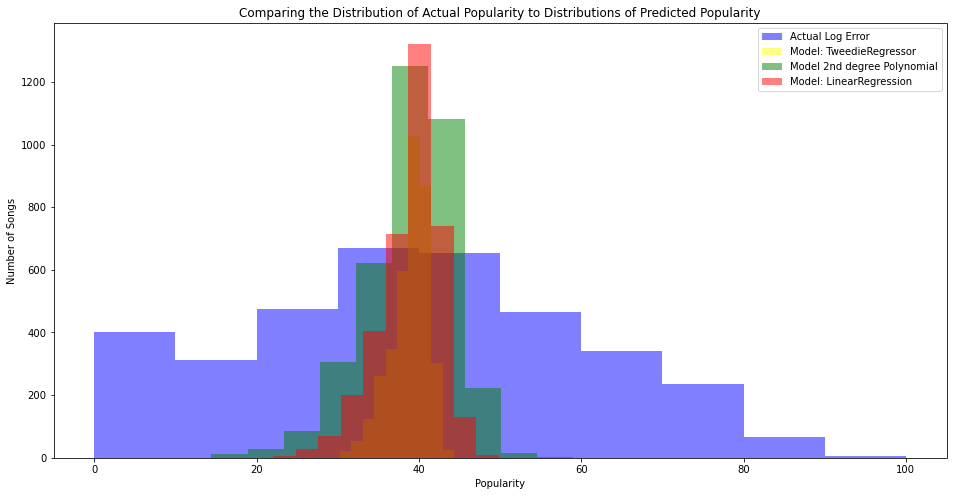

In [52]:
plt.figure(figsize=(16,8))
plt.hist(y_validate.popularity, color='blue', alpha=.5, label="Actual Log Error")
plt.hist(y_validate.popularity_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.popularity_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.hist(y_validate.popularity_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.title("Comparison of the models using all the features")
plt.xlabel("Popularity")
plt.ylabel("Number of Songs")
plt.title("Comparing the Distribution of Actual Popularity to Distributions of Predicted Popularity")
plt.legend()
plt.show()

The polynomial model histogram is also slightly more fit to actual predictions.

## Evaluate on Test

In [53]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['popularity_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.popularity, y_test.popularity_pred_lm2)**(1/2)

print("Out-of-Sample Performance RMSE: ", rmse_test)
lm2_test_rmse = rmse_test

Out-of-Sample Performance RMSE:  20.571929953911248


In [54]:
(baseline_rmse - lm2_test_rmse) / baseline_rmse * 100

1.396228241919553

Evaluating on the test dataset, the Polynomial Model beats baseline by 1.4%

# Conclusion
## Key takeaways:
### Features that matter?
The features that matter the most are danceability, loudness, and mode. This means that if a song is danceable, loud, and in a major key, the more likely it is going to be more popular.

### Modeling
The data was modeled through several regression algorithms with all features, clusters, and a few features as options. The polynomial model with all features included was the top performer with an RMSE of 20.57 when evaluated on the test dataset.

## Recommendations:
When modeling top artist popularity per user, including a more broad generic dataset will provide consistency and variety in modeling.

## Next Steps:
Acquire more data from Spotify to diversify the dataset, building a model from the diverse dataset to apply to user's top artists.